In [1]:
from qutip import *
import math as math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import scipy as scipy
import matplotlib.animation as animation
from tqdm import tqdm
import sys
import matplotlib.gridspec as gridspec

Parámetros del sistema

In [129]:
w_0 = 0.5 # Frecuencia natural x>0
W_0 = 8 # Frecuencia natural x<0
amort = 0.125 # constante de amortiguamiento
f_0 = 4 # Amplitud de la fuerza por unidad de masa
m = 1 # masa del oscilador
N = 100 # Numero de fonones
w = [1.8] # frecuencia de la fuerza externa
X_0 = 7 # Condición inicial
n = np.size(w)

Frecuencia natural del oscilador

In [3]:
def W(x): # frecuecia angular
    return W_0 - (W_0-w_0)*np.heaviside(x,w_0)

Desarrollo del potencial en la base de autoestados del oscilador armónico cuántico

In [4]:
def U(x):
    return 0.5*m*x**2*W(x)**2

In [5]:
def autoest(n,x,conj): # autoestados del oscilador armónico cuántico
    pol_Herm = scipy.special.hermite(n)
    xi = np.sqrt(m*w_0)*x
    phi = (m*w_0/(np.pi))**(0.25)*(1/math.sqrt(2**n*np.math.factorial(n)))*pol_Herm(xi)*np.exp(-(xi**2)/2)
    if conj == True:
        return np.conj(phi)
    return phi

In [6]:
x = np.linspace(-25,25,1500) # Estas x tienen unidades de posición
Unm = np.zeros([N,N],dtype=complex)
U_x = np.zeros(np.size(x),dtype=complex)

for i in tqdm(range(N)):
    for j in range(N):
        Unm[i][j] = scipy.integrate.simpson(autoest(j,x,False)*autoest(i,x,True)*U(x),x)
        U_x = U_x + autoest(j,x,False)*autoest(i,x,True)*Unm[i][j]

U_q = Qobj(Unm)

100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


c:\Users\rodri\anaconda3\envs\QuantumChaos\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\rodri\anaconda3\envs\QuantumChaos\lib\site-packages\matplotlib\transforms.py:2877: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


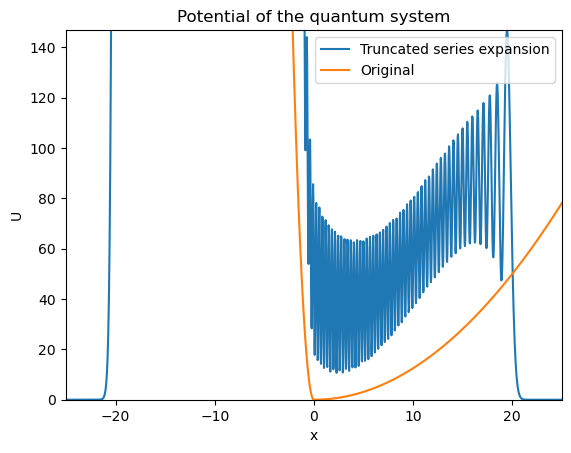

In [7]:
fig1 = plt.figure()
plt.plot(x,U_x,label='Truncated series expansion')
plt.plot(x,U(x),label='Original')
plt.xlim([np.min(x),np.max(x)])
plt.ylim([0,np.max(U_x[(np.size(U_x)//2):])])
plt.title('Potential of the quantum system')
plt.xlabel('x')
plt.ylabel('U')
plt.legend()
plt.show()

In [8]:
fig1.savefig('Quantum_potential (N = '+str(N)+' phonons).png')

Simulación de la dinámica cuántica

In [73]:
dt = 0.05 # Paso de tiempo
tf = 250 # Tiempo de medida (se asume que t0 = 0)
tvec = np.linspace(0,tf,int(tf/dt)+1) # Vector de instantes de tiempo
est = 0 # instante de tiempo a partir del que representamos para quedarnos con el movimiento estacionario

In [10]:
lines = ['dt = '+str(dt),'tf = '+str(tf),'w_0 = '+str(w_0),'W_0 = '+str(W_0),'f_0 = '+str(f_0),'amort = '+str(amort),'N = '+str(N),'X_0 = '+str(X_0),'w = '+str(w)]
with open('param.txt', 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

In [74]:
def check_state(psi):
    check = np.sum(psi[-3:])

    if check >= 1e-2:
        return sys.exit("Warning: add more phonons")

In [75]:
# Estado inicial:
psi0 = coherent(N,X_0*math.sqrt(0.5)*math.sqrt(w_0*m))

x_0 = expect(position(N),psi0)/math.sqrt(w_0*m) 
p_0 = expect(momentum(N),psi0)*math.sqrt(w_0*m)

# Estado para comparar:
# psi02 = coherent(N,math.sqrt(0.6))

In [76]:
def H1coeff(t,args):
    return -f_0*m*np.cos(args['w']*t)

In [132]:
result = []
H0 = w_0*momentum(N)**2/2+U_q
H1 = position(N)/math.sqrt(w_0*m)
x_exp = position(N)/math.sqrt(w_0*m)
p_exp = momentum(N)*math.sqrt(w_0*m)
x2_exp = position(N)**2/(w_0*m)
p2_exp = momentum(N)**2*(w_0*m)
coll = math.sqrt(2*amort*m)*destroy(N)
options = Options(store_states=True,nsteps=100000,ntraj=1)

for i in tqdm(range(n)):
    args = {'w': w[i]}
    H = [H0,[H1,H1coeff]]
    result.append(mcsolve(H, psi0, tvec, [coll], [x_exp,p_exp,x2_exp,p2_exp],options=options,args=args))
    # result2 = mesolve(H, psi02, tvec, [], [position(N)/math.sqrt(w_0*m),momentum(N)*math.sqrt(w_0*m),position(N)**2/(w_0*m),momentum(N)**2*(w_0*m)],options=options)

  0%|          | 0/1 [00:00<?, ?it/s]

Total run time: 510.48s


100%|██████████| 1/1 [08:30<00:00, 510.69s/it]


Overlap integrals

In [78]:
O = []
coh = []

for j in range(n):
    aux = []
    aux2 = []
    for i in tqdm(range(np.size(tvec))): 
        psi = result[j].states[0][i]
        #check_state(psi)
        alpha = expect(destroy(N),psi)
        
        psi_t = coherent(N,alpha)
        aux.append(psi.overlap(psi0))
        aux2.append(psi_t.overlap(psi))
    O.append(aux)
    coh.append(aux2)

100%|██████████| 5001/5001 [00:48<00:00, 102.31it/s]


In [79]:
S = []
P = []

for i in tqdm(range(np.size(tvec))):
    Q = ket2dm(result[0].states[0][i])
    S.append(entropy_vn(Q))
    P.append(np.trace(Q*Q))

100%|██████████| 5001/5001 [00:43<00:00, 113.96it/s]


In [80]:
fou = []
nO = np.size(result[0].expect[0][int(est/dt):])
freq = np.fft.fftfreq(nO, dt)[:nO//2]

for i in tqdm(range(n)):
    fou.append(scipy.fft.fft(result[i].expect[0][int(est/dt):]))

100%|██████████| 1/1 [00:00<00:00, 501.65it/s]


In [134]:
desv_x = []
desv_p = []

for i in range(n):
    desv_x.append(np.sqrt(result[i].expect[2]-result[i].expect[0]*result[i].expect[0]))
    desv_p.append(np.sqrt(result[i].expect[3]-result[i].expect[1]*result[i].expect[1]))

Comparación con caso clásico

In [82]:
def EDO(t,y,w): # Ecuaciones modificadas, las del oscilador amortiguado clásico serían [v,-W(x)**2*x-2*amort*v+f_0*np.cos(w*t)]
    x,v = y
    return [v-amort*x,-W(x)**2*x-amort*v+f_0*np.cos(w*t)]

In [133]:
pos = []
mom = []
xp = []
pp = []

for i in tqdm(range(np.size(w))):

    sol = scipy.integrate.solve_ivp(EDO, [0,tf], [x_0,p_0/m], method = 'Radau',t_eval = tvec,args = [w[i]])
    x,v = sol.y
    pos.append(x)
    mom.append(v*m)
    
    T = 2*np.pi/w[i] # Periodo fuerza externa
    Np = int(tf/T) # Número de puntos del diagrama de Poincaré
    ind = np.array([np.searchsorted(tvec,T*(j+1)) for j in range(Np-1)]) # Calculamos los índices del diagrama de Poincaré
    
    xp.append(x[ind]) # Asignamos índices encontrados en tiempos con posiciones y velocidades (/max(x[ind]))
    pp.append(v[ind]*m)

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Save data and figures

In [84]:
rep = n-1 # w para la que queremos las figuras
est = 150

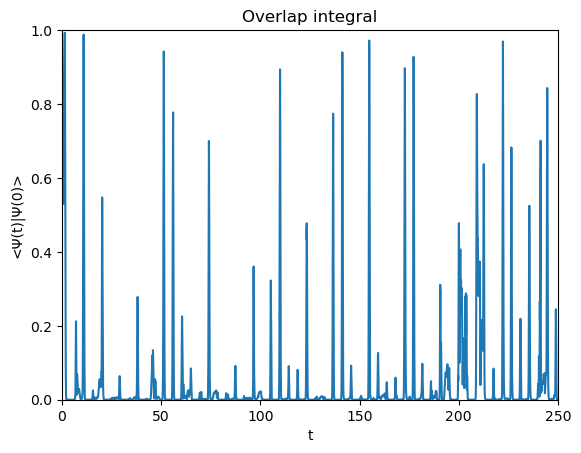

In [85]:
fig2 = plt.figure()
plt.plot(tvec,np.abs(O[rep]))
plt.xlim([0,tf])
plt.ylim([0,1])
plt.title('Overlap integral')
plt.xlabel('t')
plt.ylabel('<Ψ(t)|Ψ(0)>')
plt.show()

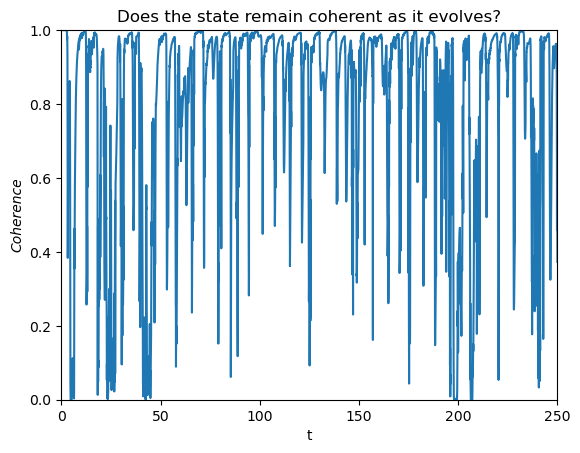

In [86]:
fig3 = plt.figure()
plt.plot(tvec,np.abs(coh[rep]))
plt.xlim([0,tf])
plt.ylim([0,1])
plt.title('Does the state remain coherent as it evolves?')
plt.xlabel('t')
plt.ylabel('Coherence', style = 'italic')
plt.show()

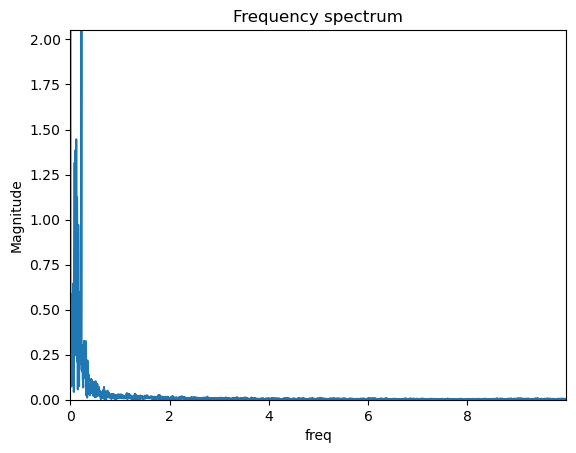

In [87]:
fig4 = plt.figure()
plt.plot(freq,(2/nO)*np.abs(fou[rep][:nO//2]))
plt.xlim([np.min(freq),np.max(freq)])
plt.ylim([0,np.max((2/nO)*abs(fou[rep][1:]))])
plt.title('Frequency spectrum')
plt.xlabel('freq')
plt.ylabel('Magnitude')
plt.show()

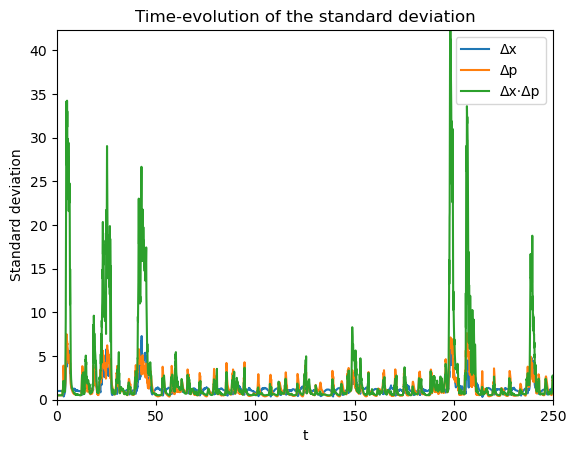

In [88]:
fig5 = plt.figure()
plt.plot(tvec,desv_x[rep], label = 'Δx')
plt.plot(tvec,desv_p[rep], label = 'Δp')
plt.plot(tvec,desv_x[rep]*desv_p[rep], label = 'Δx·Δp')
plt.ylim([0,np.max([desv_p[rep],desv_x[rep]*desv_p[rep],desv_x[rep]])])
plt.xlim([0,tf])
plt.title('Time-evolution of the standard deviation')
plt.xlabel('t')
plt.ylabel('Standard deviation')
plt.legend()
plt.show()

c:\Users\rodri\anaconda3\envs\QuantumChaos\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


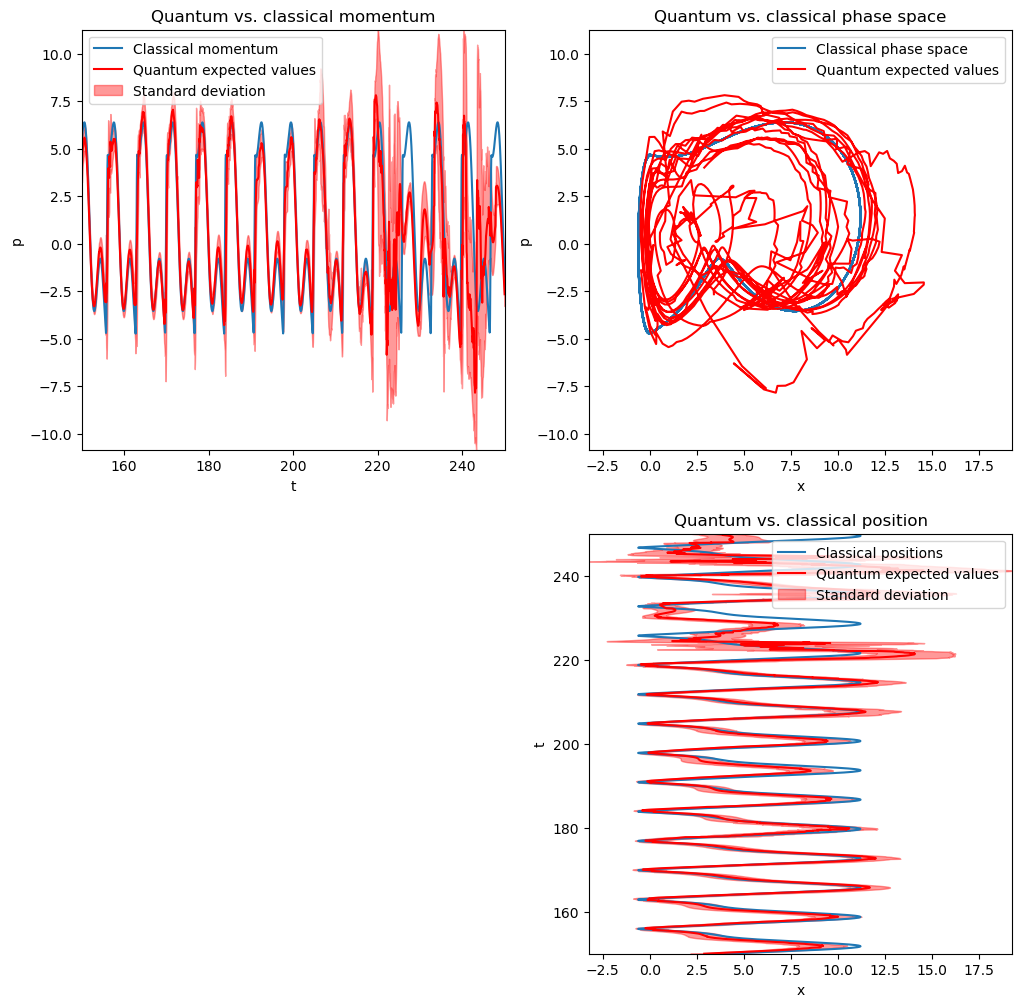

In [135]:
fig6 = plt.figure(figsize=(12,12), constrained_layout=True)

gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax3 = plt.subplot(gs[0, :2], )
ax1 = plt.subplot(gs[0, 2:])
ax2 = plt.subplot(gs[1, 2:])

ax1.plot(pos[rep][int(est/dt):],mom[rep][int(est/dt):],label='Classical phase space')
ax1.plot(result[rep].expect[0][int(est/dt):],result[rep].expect[1][int(est/dt):],label='Quantum expected values',color = 'red')
ax1.set_ylim([np.min([result[rep].expect[1][int(est/dt):]-desv_p[rep][int(est/dt):],mom[rep][int(est/dt):]]),np.max([result[rep].expect[1][int(est/dt):]+desv_p[rep][int(est/dt):],mom[rep][int(est/dt):]])])
ax1.set_xlim([np.min([result[rep].expect[0][int(est/dt):]-desv_x[rep][int(est/dt):],pos[rep][int(est/dt):]]),np.max([result[rep].expect[0][int(est/dt):]+desv_x[rep][int(est/dt):],pos[rep][int(est/dt):]])])
ax1.set_title('Quantum vs. classical phase space')
ax1.set_xlabel('x')
ax1.set_ylabel('p')
ax1.legend()

ax2.plot(pos[rep][int(est/dt):],tvec[int(est/dt):],label='Classical positions')
ax2.plot(result[rep].expect[0][int(est/dt):],tvec[int(est/dt):],label='Quantum expected values', color = 'red')
ax2.fill_betweenx(tvec[int(est/dt):],result[rep].expect[0][int(est/dt):]-desv_x[rep][int(est/dt):],result[rep].expect[0][int(est/dt):]+desv_x[rep][int(est/dt):],alpha = 0.4, color = 'red', label = 'Standard deviation')
ax2.set_xlim([np.min([result[rep].expect[0][int(est/dt):]-desv_x[rep][int(est/dt):],pos[rep][int(est/dt):]]),np.max([result[rep].expect[0][int(est/dt):]+desv_x[rep][int(est/dt):],pos[rep][int(est/dt):]])])
ax2.set_ylim([est,tf])
ax2.set_title('Quantum vs. classical position')
ax2.set_ylabel('t')
ax2.set_xlabel('x')
ax2.legend()

ax3.plot(tvec[int(est/dt):],mom[rep][int(est/dt):],label='Classical momentum')
ax3.plot(tvec[int(est/dt):],result[rep].expect[1][int(est/dt):],label='Quantum expected values', color = 'red')
ax3.fill_between(tvec[int(est/dt):],result[rep].expect[1][int(est/dt):]-desv_p[rep][int(est/dt):],result[rep].expect[1][int(est/dt):]+desv_p[rep][int(est/dt):],alpha = 0.4, color = 'red', label = 'Standard deviation')
ax3.set_ylim([np.min([result[rep].expect[1][int(est/dt):]-desv_p[rep][int(est/dt):],mom[rep][int(est/dt):]]),np.max([result[rep].expect[1][int(est/dt):]+desv_p[rep][int(est/dt):],mom[rep][int(est/dt):]])])
ax3.set_xlim([est,tf])
ax3.set_title('Quantum vs. classical momentum')
ax3.set_xlabel('t')
ax3.set_ylabel('p')
ax3.legend()

In [90]:
fig2.savefig('Overlap (ω = '+str(format(w[rep],'.3f'))+' s⁻¹).png')

In [91]:
fig3.savefig('Coherence (ω = '+str(format(w[rep],'.3f'))+' s⁻¹).png')

In [92]:
fig4.savefig('Frequency spectrum (ω = '+str(format(w[rep],'.3f'))+' s⁻¹).png')

In [93]:
fig5.savefig('Standard deviation (ω = '+str(format(w[rep],'.3f'))+' s⁻¹).png')

In [94]:
fig6.savefig('Classical_vs_quantum (ω = '+str(format(w[rep],'.3f'))+' s⁻¹).png')

C:\Users\rodri\AppData\Local\Temp\ipykernel_38448\1291524422.py:1: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig6.savefig('Classical_vs_quantum (ω = '+str(format(w[rep],'.3f'))+' s⁻¹).png')


In [95]:
#sys.exit()

Wigner function evolution

In [138]:
Wigner = []
wig_xvec = np.linspace(-1,11,100)
wig_pvec = np.linspace(-11,11,100)
indW = np.array([np.searchsorted(tvec,i*0.5) for i in range(tf*2)]) # Calculamos los índices
tW = tvec[indW]

for i in tqdm(range(np.size(tW))):   
    Wigner.append(wigner(result[rep].states[0][int(tW[i]/dt)], wig_xvec, wig_pvec))

  1%|          | 3/500 [00:02<07:05,  1.17it/s]


KeyboardInterrupt: 

In [139]:
T = 2*np.pi/w[rep]
Np = int(tf/T) # Número de puntos que usamos en el promedio
indW2 = np.array([np.searchsorted(tvec,T*(i+1)) for i in range(Np-1)]) # Calculamos los índices
aux = 0
num = 40

for i in tqdm(indW2[-num:]):
    aux += wigner(result[rep].states[0][i], wig_xvec, wig_pvec)
    
qpoin = aux/num

100%|██████████| 40/40 [00:26<00:00,  1.50it/s]


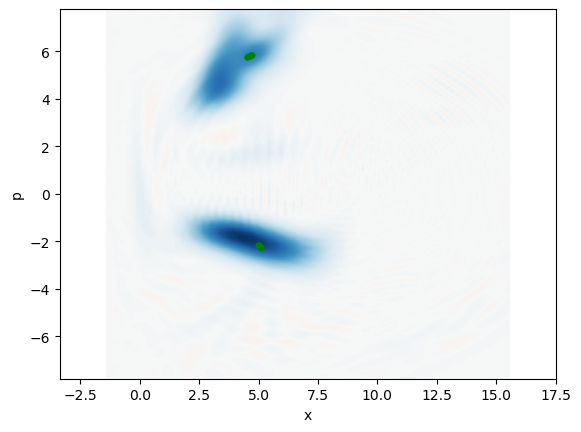

In [140]:
wmap = wigner_cmap(qpoin)
nrm = mpl.colors.Normalize(-qpoin.max(), qpoin.max())
plt.contourf(wig_xvec/math.sqrt(w_0*m), wig_pvec*math.sqrt(w_0*m), qpoin, 100, cmap=cm.RdBu, norm=nrm)
plt.xlim([np.min(wig_xvec),np.max(wig_xvec)])
plt.ylim([np.min(wig_pvec),np.max(wig_pvec)])
plt.plot(xp[0][-num:],pp[0][-num:],'g .')
#plt.plot(pos[0][-1000:],mom[0][-1000:])
#plt.title('Evolution of the Wigner function (t = '+str(format(tW[num],'.3f'))+' s)')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('p')
plt.savefig('Qsec (ω = '+str(format(w[rep],'.3f'))+' s⁻¹).png')

Amount of negativity

In [99]:
neg = []
#pos = []

for i in tqdm(range(np.shape(Wigner)[0])):
    neg.append(100*np.sum(((Wigner[i]<0)*1)*np.abs(Wigner[i]))/np.sum(np.abs(Wigner[i])))
    #pos.append(100*np.sum(((Wigner[i]>=0)*1)*np.abs(Wigner[i]))/np.sum(np.abs(Wigner[i])))

100%|██████████| 500/500 [00:00<00:00, 7065.66it/s]


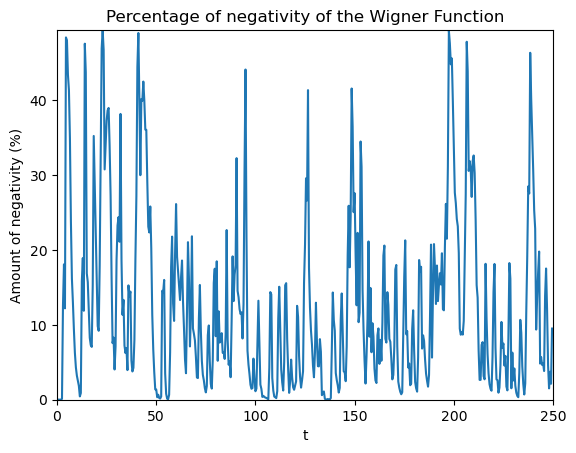

In [100]:
fig1 = plt.figure()
plt.plot(tW,neg)
plt.xlim([0,tf])
plt.ylim([0,np.max(neg)])
plt.title('Percentage of negativity of the Wigner Function')
plt.xlabel('t')
plt.ylabel('Amount of negativity (%)')
plt.show()

In [101]:
def update_Wigner(num,Wigner):
    plt.cla()
    wmap = wigner_cmap(Wigner[num])
    nrm = mpl.colors.Normalize(-Wigner[num].max(), Wigner[num].max())
    plt.contourf(wig_xvec, wig_pvec, Wigner[num], 100, cmap=cm.RdBu, norm=nrm)
    plt.xlim([np.min(wig_xvec),np.max(wig_xvec)])
    plt.ylim([np.min(wig_pvec),np.max(wig_pvec)])
    plt.title('Evolution of the Wigner function (t = '+str(format(tW[num],'.3f'))+' s)')
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('p')

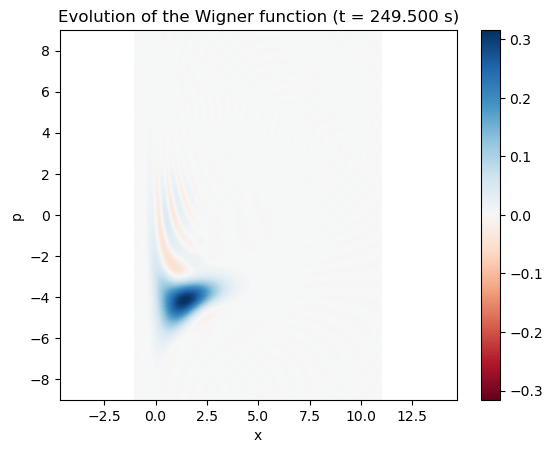

In [102]:
imW = plt.figure()
wmap = wigner_cmap(Wigner[0])
nrm = mpl.colors.Normalize(-Wigner[0].max(), Wigner[0].max())
figW = plt.contourf(wig_xvec, wig_pvec, Wigner[0], 100, cmap=cm.RdBu, norm=nrm)
plt.colorbar(cm.ScalarMappable(norm=nrm, cmap=cm.RdBu))
animW = animation.FuncAnimation(imW, update_Wigner, range(np.size(tW)), fargs = (Wigner, ), interval = 25)
animW.save('WIGNER (ω = '+str(format(w[rep],'.3f'))+' s⁻¹).gif')
animW.save('WIGNER (ω = '+str(format(w[rep],'.3f'))+' s⁻¹).mp4')

In [103]:
fig1.savefig('Negativity (ω = '+str(format(w[rep],'.3f'))+' s⁻¹).png')